# HyperParameter Tuning : Experiments and Reports
## Advanced Machine Learning
### T Sanjev Vishnu

In [257]:
import tensorflow as tf
import numpy as np
import pandas as pd
import numpy as np
import os
import pydicom
import matplotlib.pyplot as plt
import cv2 as cv
from PIL import Image, ImageDraw
import random
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dropout, Reshape, Conv2DTranspose, concatenate, Input, BatchNormalization
from tensorflow.keras import models, layers
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [85]:
def pad_up_to(t, max_in_dims, constant_values):
    s = tf.shape(t)
    paddings = [[0, m-s[i]] for (i,m) in enumerate(max_in_dims)]
    return tf.pad(t, paddings, 'CONSTANT', constant_values=constant_values)

In [2]:
path = "TrainingSet/"
y = []
for i in range(1,17):
    dynamic_path = path + "P" + str(i).zfill(2) + "list.txt"
    #print(dynamic_path)
    f = open(dynamic_path)
    data = f.read()
    data = data.split("\n")
    for i in data:
        if len(i) > 1:
            y.append(i[-28:])

In [5]:
images = [line[:8] for line in y]

In [7]:
img_ext = ".dcm"
i = 0
x_train = []
for i in range(len(images)):
    if i%2 == 0:
        ds_img = pydicom.dcmread("TrainingSet/"+images[i]+img_ext)
        numpy_array = ds_img.pixel_array
        #cv.imwrite(images[i]+".jpg",numpy_array)
        x_train.append(numpy_array)
        #plt.figure(frameon=False)
        #plt.title("Patient ID "+images[i])
        #plt.axis("off")
        plt.imsave(images[i]+".png",ds_img.pixel_array)
        #plt.imshow(ds_img.pixel_array)

In [107]:
y_train = []
for h in range(243):
    cont_f = open("TrainingSet/"+y[(h*2)])
    cont_f = cont_f.read()
    coordinates = cont_f.split("\n")
    c = []
    for i in range(len(coordinates) - 1):
        cc = coordinates[i].split()
        x1, y1 = float(cc[0]), float(cc[1])
        ccc = (x1, y1)
        c.append(ccc)
    ocont_f = open("TrainingSet/"+y[(h*2)+1])
    ocont_f = ocont_f.read()
    ocoordinates = ocont_f.split("\n")
    o = []
    for i in range(len(ocoordinates) - 1):
        oo = ocoordinates[i].split()
        x1, y1 = float(oo[0]), float(oo[1])
        ooo = (x1, y1)
        o.append(ooo)
    #print(images[2*h])
    w, height = x_train[h].shape
    oim = Image.new("L",size=(height, w))
    odraw = ImageDraw.Draw(oim)
    iim = Image.new("L",size=(height, w))
    idraw = ImageDraw.Draw(iim)
    idraw.polygon(c, fill="white")
    odraw.polygon(o, fill="white")
    oim.save("OuterContour/"+images[h*2]+"o"+".png","PNG")
    iim.save("InnerContour/"+images[h*2]+"i"+".png","PNG")
    yy = cv.imread("InnerContour/"+images[h*2]+"i"+".png",0)
    #print(yy.shape)
    y_train.append(yy)
    if h%10 == 2:
        print("*", end="")

*************************

In [254]:
X, Y  = [], []
for i in range(len(x_train)):
    #if x_train[i].shape == (256,216):
    wid, hei = x_train[i].shape
    temp = tf.convert_to_tensor((x_train[i].reshape(1,wid,hei,1))/255.000, dtype=tf.float32)
    X.append(pad_up_to(temp, [1,256,256,1], 0))
    wid, hei = y_train[i].shape
    temp = tf.convert_to_tensor((y_train[i].reshape(1,wid,hei,1))/255.000, dtype=tf.float32)
    Y.append(pad_up_to(temp, [1,256,256,1], 0))
    #print(x_train[i].shape, y_train[i].shape)

In [304]:
#print(type(Y))
def split_dataset(split):
    if split <= 1 and split > 0:
        split_point = int(len(X) - split*len(X))
        train_split_X = X[:split_point]
        train_split_Y = Y[:split_point]
        test_split_X = X[split_point:]
        test_split_Y = Y[split_point:]
        tr_lsdx = tf.data.Dataset.from_tensor_slices(train_split_X)
        tr_lsdy = tf.data.Dataset.from_tensor_slices(train_split_Y)
        tr_lsdd = tf.data.Dataset.zip((tr_lsdx, tr_lsdy))
        ts_lsdx = tf.data.Dataset.from_tensor_slices(test_split_X)
        ts_lsdy = tf.data.Dataset.from_tensor_slices(test_split_Y)
        ts_lsdd = tf.data.Dataset.zip((ts_lsdx, ts_lsdy))
        return tr_lsdd, ts_lsdd
    else :
        return("Split cannot be negative")


In [149]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [474]:
def conv2d_block(input_tensor,l1, l2, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same', kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [475]:
def get_unet(input_img,l1, l2, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img,l1, l2, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1,l1, l2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2,l1, l2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3,l1, l2, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4,l1, l2, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6,l1, l2, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7,l1, l2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8,l1, l2, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same',kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9,l1, l2, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model1 = models.Model(inputs=[input_img], outputs=[outputs])
    return model1

In [466]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

In [487]:
def loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred))





In [476]:
model1.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_241 (Conv2D)             (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_138 (BatchN (None, 256, 256, 16) 64          conv2d_241[0][0]                 
__________________________________________________________________________________________________
activation_137 (Activation)     (None, 256, 256, 16) 0           batch_normalization_138[0][0]    
____________________________________________________________________________________________

In [477]:
def dice_metric_plot(m,titl):
    plt.figure(figsize = (8,8))
    plt.title(titl)
    loss_normal = max(np.max(m.history["loss"]), np.max(m.history["val_loss"]))
    plt.plot(m.history["loss"]/loss_normal, label="loss")
    plt.plot(m.history["val_loss"]/loss_normal, label="val_loss")
    plt.plot(m.history["dice_coefficient"], label="dice_coefficient")
    plt.plot(m.history["val_dice_coefficient"], label="val_dice_coefficient")
    plt.plot( np.argmax(m.history["val_dice_coefficient"]), np.max(m.history["val_dice_coefficient"]), marker=6, color="b", label="Maxima")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Metrics")
    plt.legend();
    plt.savefig(str(m)+".png")

In [ ]:
for image, mask in lsdd.take(100):
    pred_mask = dicelossmodel.predict(image)
    #print(tf.shape(pred_mask))
    sample_image, sample_mask, sample_pred_mask = tf.reshape(image, [ 256, 256, 1]), tf.reshape(mask, [ 256, 256, 1]), tf.reshape(pred_mask, [ 256, 256, 1])
    display([sample_image, sample_mask, sample_pred_mask])

In [488]:
def experiment1(split_percent, batch_size, epochs, lamb1, lamb2):
    im_width = 256
    im_height = 256
    input_img = Input((im_height, im_width, 1), name='img')
    dicelossmodel = get_unet(input_img,lamb1, lamb2, n_filters=16, dropout=0.05, batchnorm=True)
    dicelossmodel.compile(optimizer=Adam(), loss = loss , metrics=[dice_coefficient])
    tra, tes = split_dataset(split_percent)
    diceresults = dicelossmodel.fit(tra, batch_size = batch_size, epochs = epochs, validation_data = tes)
    dice_metric_plot(diceresults, "BCE - Data Split : "+str(split_percent*100)+"% , Batch Size = "+ str(batch_size) + " Lambda 1 = "+str(lamb1)+" Lambda 2 = "+str(lamb2))

Epoch 1/15
194/194 [==============================] - 66s 338ms/step - loss: 2.4042 - dice_coefficient: 0.1974 - val_loss: 3.0428 - val_dice_coefficient: 0.0999
Epoch 2/15
194/194 [==============================] - 65s 337ms/step - loss: 1.5097 - dice_coefficient: 0.3358 - val_loss: 2.2203 - val_dice_coefficient: 0.2434
Epoch 3/15
194/194 [==============================] - 63s 327ms/step - loss: 0.9611 - dice_coefficient: 0.4916 - val_loss: 1.4743 - val_dice_coefficient: 0.4197
Epoch 4/15
194/194 [==============================] - 63s 326ms/step - loss: 0.7244 - dice_coefficient: 0.5855 - val_loss: 1.6175 - val_dice_coefficient: 0.3875
Epoch 5/15
194/194 [==============================] - 64s 331ms/step - loss: 0.6068 - dice_coefficient: 0.6339 - val_loss: 1.5183 - val_dice_coefficient: 0.4426
Epoch 6/15
194/194 [==============================] - 64s 329ms/step - loss: 0.6067 - dice_coefficient: 0.6432 - val_loss: 1.5960 - val_dice_coefficient: 0.3751
Epoch 7/15
194/194 [==============

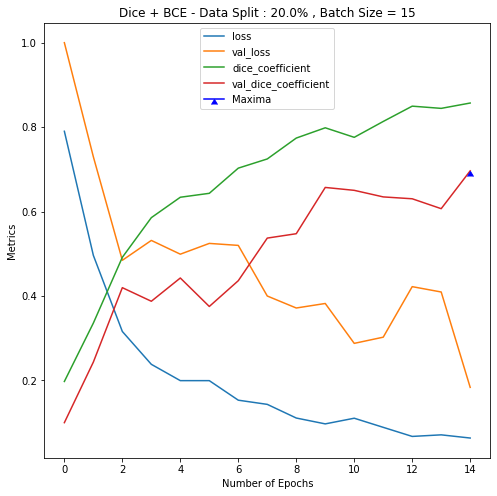

In [461]:
experiment1(0.2, 15, 15)

Epoch 1/5
194/194 [==============================] - 59s 303ms/step - loss: 53.2470 - dice_coefficient: 0.2027 - val_loss: 5.9899 - val_dice_coefficient: 0.1307
Epoch 2/5
194/194 [==============================] - 59s 304ms/step - loss: 4.5196 - dice_coefficient: 0.2568 - val_loss: 5.5974 - val_dice_coefficient: 0.1159
Epoch 3/5
194/194 [==============================] - 59s 304ms/step - loss: 4.0574 - dice_coefficient: 0.2896 - val_loss: 5.2572 - val_dice_coefficient: 0.1797
Epoch 4/5
194/194 [==============================] - 59s 304ms/step - loss: 3.9849 - dice_coefficient: 0.2902 - val_loss: 5.3519 - val_dice_coefficient: 0.1370
Epoch 5/5
194/194 [==============================] - 58s 298ms/step - loss: 3.8826 - dice_coefficient: 0.3007 - val_loss: 5.7433 - val_dice_coefficient: 0.0990


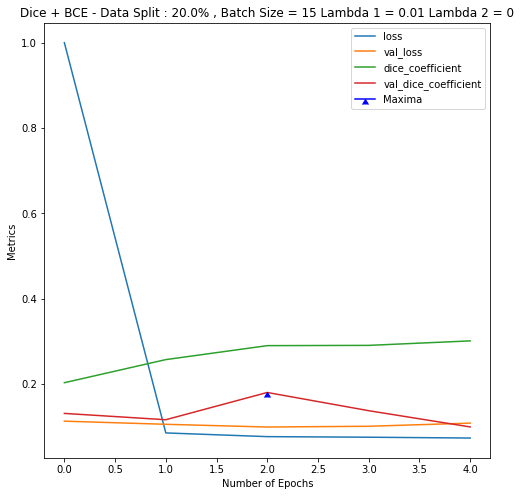

In [479]:
experiment1(0.2,15,5, 0.01, 0)

Epoch 1/10
145/145 [==============================] - 48s 328ms/step - loss: 663.5779 - dice_coefficient: 0.1119 - val_loss: 32.4188 - val_dice_coefficient: 0.0733
Epoch 2/10
145/145 [==============================] - 47s 324ms/step - loss: 22.7729 - dice_coefficient: 0.1573 - val_loss: 20.4340 - val_dice_coefficient: 0.0939
Epoch 3/10
145/145 [==============================] - 47s 326ms/step - loss: 19.3286 - dice_coefficient: 0.1945 - val_loss: 19.3086 - val_dice_coefficient: 0.1090
Epoch 4/10
145/145 [==============================] - 49s 340ms/step - loss: 18.4711 - dice_coefficient: 0.2072 - val_loss: 18.5358 - val_dice_coefficient: 0.1161
Epoch 5/10
145/145 [==============================] - 46s 314ms/step - loss: 17.9862 - dice_coefficient: 0.2190 - val_loss: 18.5002 - val_dice_coefficient: 0.0873
Epoch 6/10
145/145 [==============================] - 44s 304ms/step - loss: 17.6625 - dice_coefficient: 0.2181 - val_loss: 17.8203 - val_dice_coefficient: 0.1801
Epoch 7/10
145/145 [=

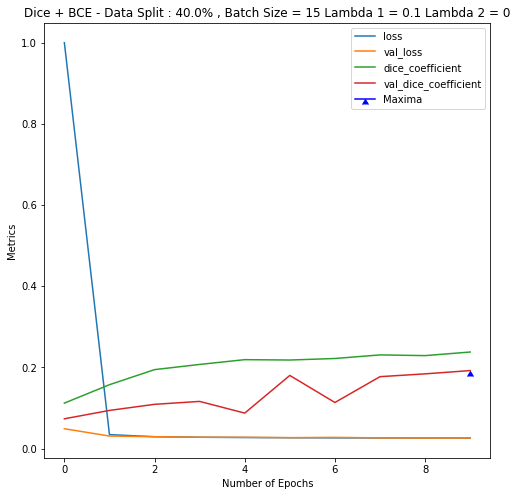

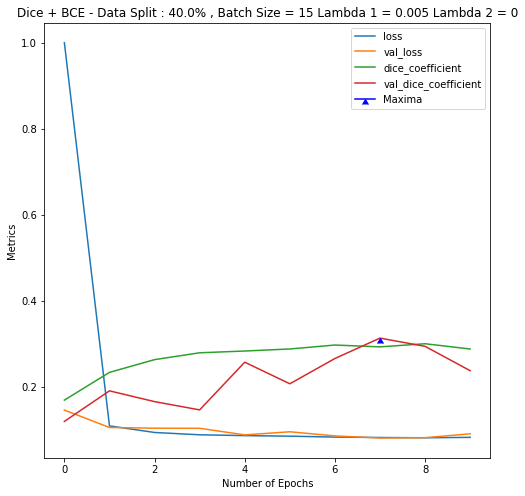

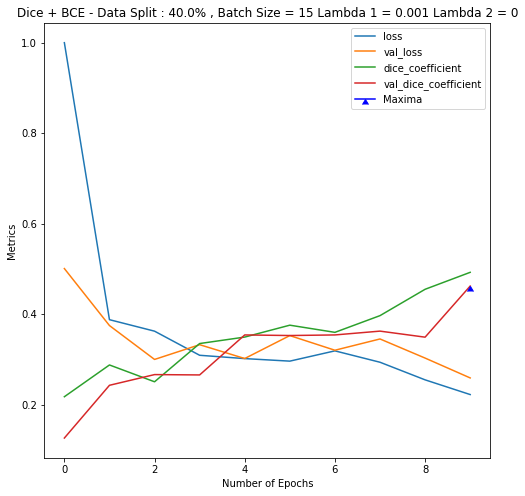

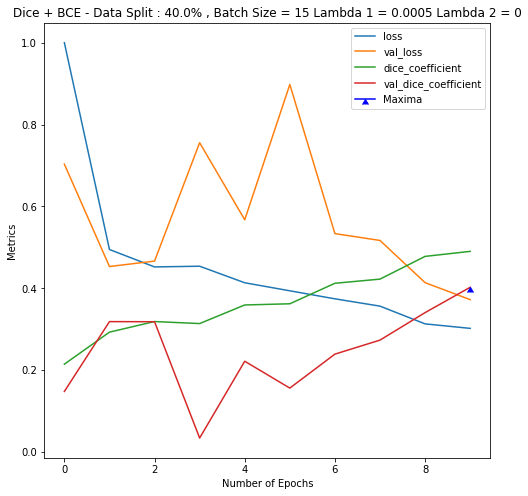

In [481]:
experiment1(0.4, 15, 10, 0.1, 0)
experiment1(0.4, 15, 10, 0.005, 0)
experiment1(0.4, 15, 10, 0.001, 0)
experiment1(0.4, 15, 10, 0.0005, 0)

Epoch 1/10
145/145 [==============================] - 45s 311ms/step - loss: 3.0978 - dice_coefficient: 0.2622 - val_loss: 5.7745 - val_dice_coefficient: 0.1382
Epoch 2/10
145/145 [==============================] - 45s 312ms/step - loss: 2.1331 - dice_coefficient: 0.3935 - val_loss: 2.8278 - val_dice_coefficient: 0.2336
Epoch 3/10
145/145 [==============================] - 46s 315ms/step - loss: 1.6807 - dice_coefficient: 0.4957 - val_loss: 2.1413 - val_dice_coefficient: 0.3739
Epoch 4/10
145/145 [==============================] - 45s 311ms/step - loss: 1.5183 - dice_coefficient: 0.5340 - val_loss: 1.8070 - val_dice_coefficient: 0.4898
Epoch 5/10
145/145 [==============================] - 46s 315ms/step - loss: 1.3661 - dice_coefficient: 0.5690 - val_loss: 3.0626 - val_dice_coefficient: 0.3466
Epoch 6/10
145/145 [==============================] - 46s 315ms/step - loss: 1.2814 - dice_coefficient: 0.6123 - val_loss: 2.4044 - val_dice_coefficient: 0.4074
Epoch 7/10
145/145 [==============

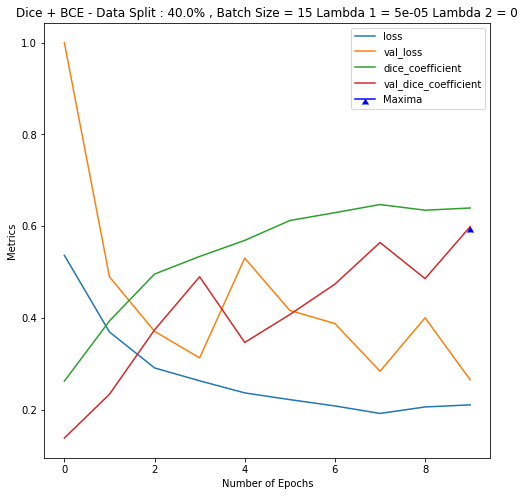

In [482]:
experiment1(0.4, 15, 10, 0.00005, 0)

Epoch 1/10
145/145 [==============================] - 47s 326ms/step - loss: 37.3791 - dice_coefficient: 0.1686 - val_loss: 7.3513 - val_dice_coefficient: 0.1096
Epoch 2/10
145/145 [==============================] - 46s 316ms/step - loss: 4.7661 - dice_coefficient: 0.2155 - val_loss: 4.0326 - val_dice_coefficient: 0.1994
Epoch 3/10
145/145 [==============================] - 46s 315ms/step - loss: 3.3940 - dice_coefficient: 0.2342 - val_loss: 3.0740 - val_dice_coefficient: 0.2328
Epoch 4/10
145/145 [==============================] - 48s 333ms/step - loss: 2.7500 - dice_coefficient: 0.2749 - val_loss: 3.1865 - val_dice_coefficient: 0.1410
Epoch 5/10
145/145 [==============================] - 44s 304ms/step - loss: 2.4699 - dice_coefficient: 0.2875 - val_loss: 2.5310 - val_dice_coefficient: 0.2187
Epoch 6/10
145/145 [==============================] - 44s 303ms/step - loss: 2.2989 - dice_coefficient: 0.3026 - val_loss: 2.3597 - val_dice_coefficient: 0.2402
Epoch 7/10
145/145 [=============

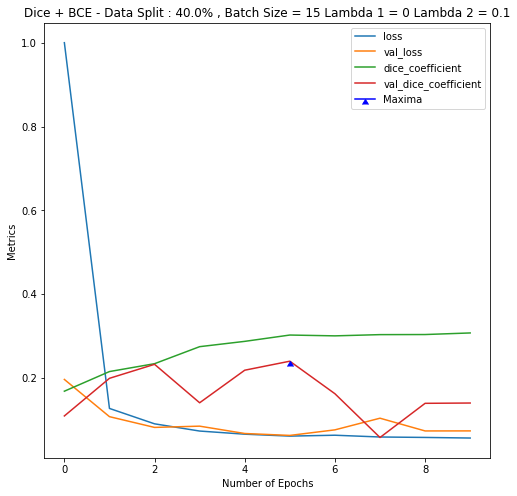

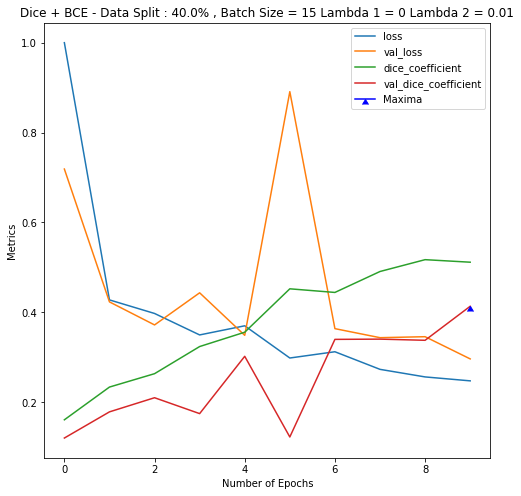

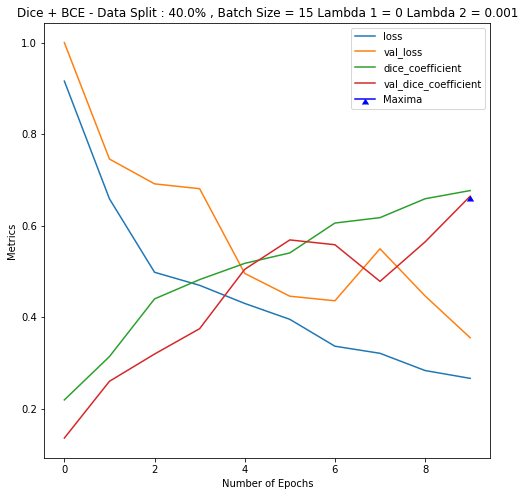

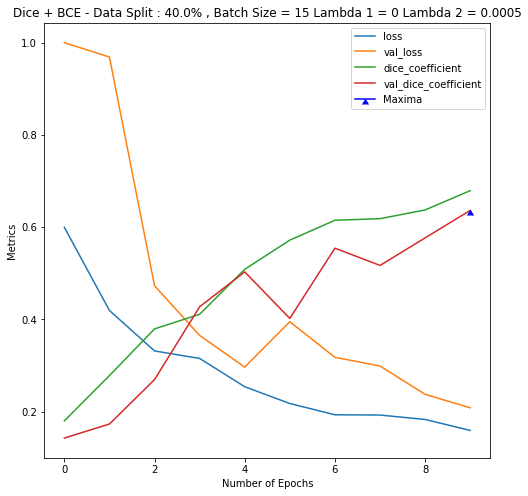

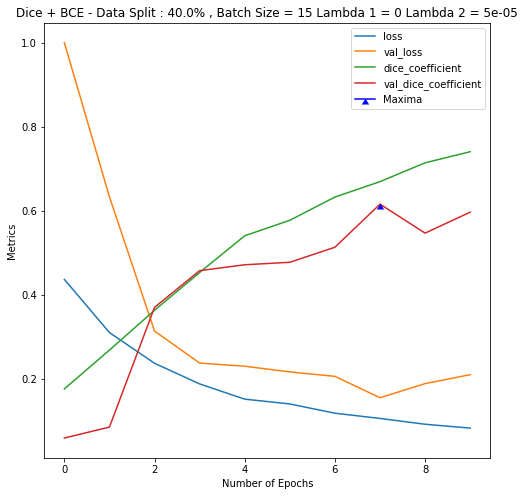

In [483]:
# Experimenting with values of Lambda 2 hyperparameter of L2 Penalty
experiment1(0.4, 15, 10, 0, 0.1)
experiment1(0.4, 15, 10, 0, 0.01)
experiment1(0.4, 15, 10, 0, 0.001)
experiment1(0.4, 15, 10, 0, 0.0005)
experiment1(0.4, 15, 10, 0, 0.00005)

Epoch 1/15
145/145 [==============================] - 48s 330ms/step - loss: 3.8506 - dice_coefficient: 0.2233 - val_loss: 4.1601 - val_dice_coefficient: 0.0880
Epoch 2/15
145/145 [==============================] - 47s 324ms/step - loss: 2.6209 - dice_coefficient: 0.3420 - val_loss: 3.2086 - val_dice_coefficient: 0.2350
Epoch 3/15
145/145 [==============================] - 49s 336ms/step - loss: 2.1103 - dice_coefficient: 0.4481 - val_loss: 3.9453 - val_dice_coefficient: 0.1092
Epoch 4/15
145/145 [==============================] - 47s 327ms/step - loss: 2.0146 - dice_coefficient: 0.4533 - val_loss: 2.9510 - val_dice_coefficient: 0.2689
Epoch 5/15
145/145 [==============================] - 47s 322ms/step - loss: 1.8615 - dice_coefficient: 0.4925 - val_loss: 2.3462 - val_dice_coefficient: 0.4088
Epoch 6/15
145/145 [==============================] - 47s 325ms/step - loss: 1.5955 - dice_coefficient: 0.5342 - val_loss: 1.9164 - val_dice_coefficient: 0.4767
Epoch 7/15
145/145 [==============

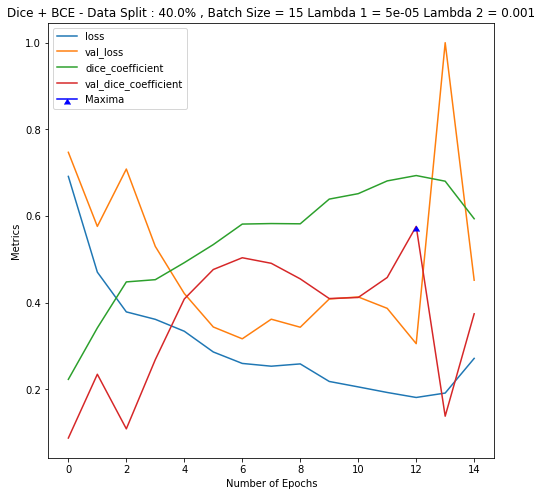

In [485]:
experiment1(0.4, 15, 15, 0.00005, 0.001)

Epoch 1/15
48/48 [==============================] - 22s 466ms/step - loss: 4.3856 - dice_coefficient: 0.1381 - val_loss: 26.5607 - val_dice_coefficient: 0.0930
Epoch 2/15
48/48 [==============================] - 22s 464ms/step - loss: 3.5451 - dice_coefficient: 0.1638 - val_loss: 5.2259 - val_dice_coefficient: 0.1300
Epoch 3/15
48/48 [==============================] - 23s 477ms/step - loss: 3.1205 - dice_coefficient: 0.1863 - val_loss: 3.6026 - val_dice_coefficient: 0.1200
Epoch 4/15
48/48 [==============================] - 22s 467ms/step - loss: 2.6623 - dice_coefficient: 0.2228 - val_loss: 3.8456 - val_dice_coefficient: 0.0823
Epoch 5/15
48/48 [==============================] - 23s 469ms/step - loss: 2.3456 - dice_coefficient: 0.2647 - val_loss: 3.4465 - val_dice_coefficient: 0.1081
Epoch 6/15
48/48 [==============================] - 23s 474ms/step - loss: 1.9425 - dice_coefficient: 0.3466 - val_loss: 2.9075 - val_dice_coefficient: 0.1656
Epoch 7/15
48/48 [===========================

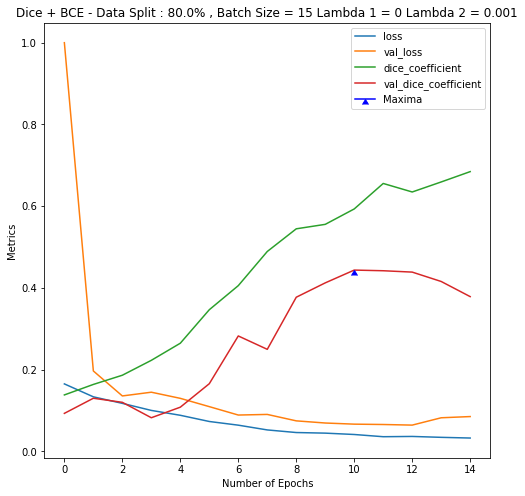

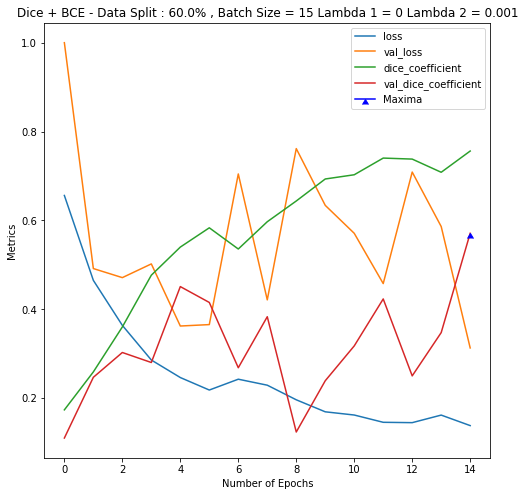

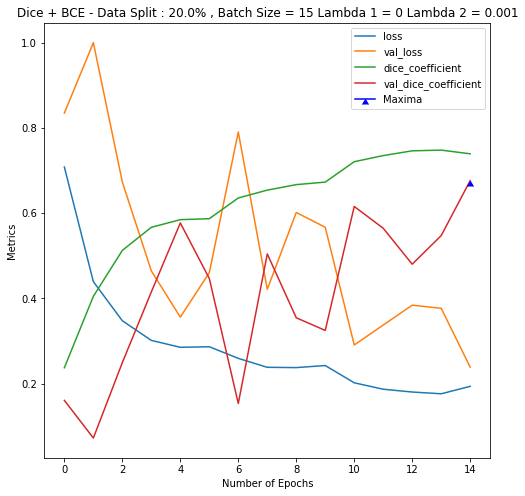

In [486]:
experiment1(0.8, 15, 15, 0, 0.001)
experiment1(0.6, 15, 15, 0, 0.001)
experiment1(0.2, 15, 15, 0, 0.001)

Epoch 1/15
48/48 [==============================] - 22s 452ms/step - loss: 0.5083 - dice_coefficient: 0.1005 - val_loss: 1.5263 - val_dice_coefficient: 0.1122
Epoch 2/15
48/48 [==============================] - 22s 454ms/step - loss: 0.3182 - dice_coefficient: 0.1008 - val_loss: 0.4457 - val_dice_coefficient: 0.1006
Epoch 3/15
48/48 [==============================] - 22s 453ms/step - loss: 0.2529 - dice_coefficient: 0.1152 - val_loss: 0.4143 - val_dice_coefficient: 0.0981
Epoch 4/15
48/48 [==============================] - 22s 454ms/step - loss: 0.2158 - dice_coefficient: 0.1207 - val_loss: 0.2437 - val_dice_coefficient: 0.1125
Epoch 5/15
48/48 [==============================] - 22s 458ms/step - loss: 0.1845 - dice_coefficient: 0.1363 - val_loss: 0.2418 - val_dice_coefficient: 0.1286
Epoch 6/15
48/48 [==============================] - 22s 456ms/step - loss: 0.1676 - dice_coefficient: 0.1501 - val_loss: 0.1965 - val_dice_coefficient: 0.1412
Epoch 7/15
48/48 [============================

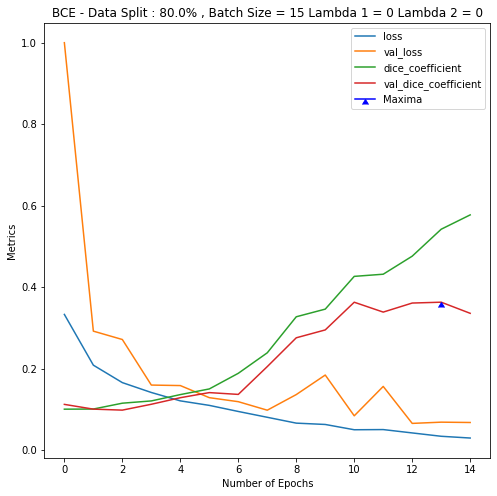

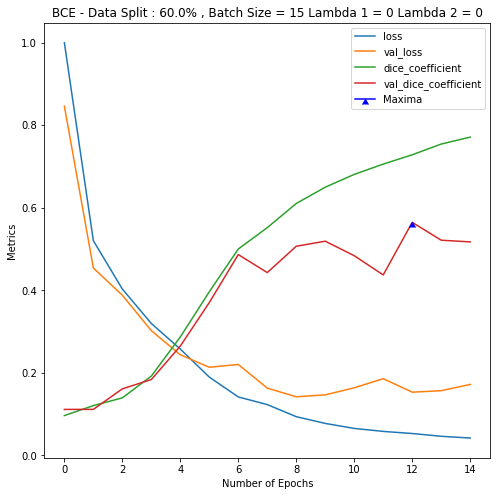

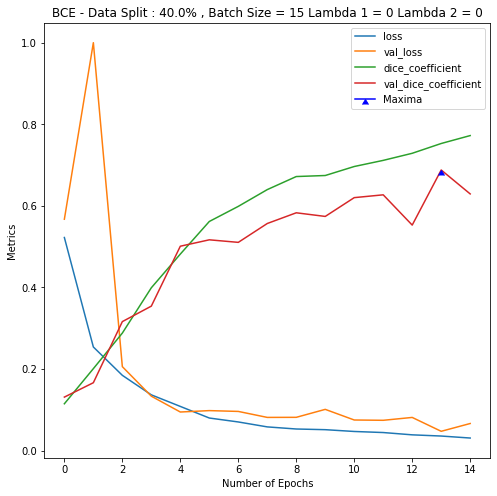

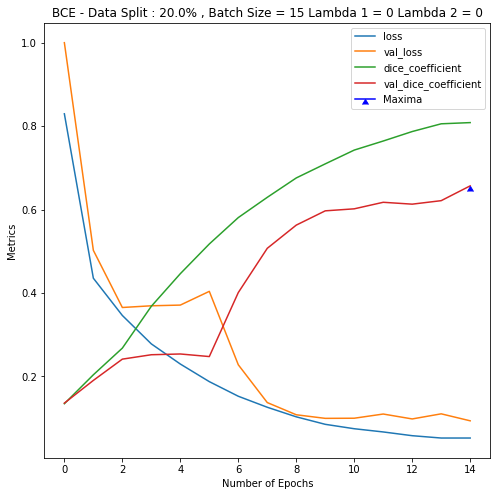

In [489]:
experiment1(0.8, 15, 15, 0, 0)
experiment1(0.6, 15, 15, 0, 0)
experiment1(0.4, 15, 15, 0, 0)
experiment1(0.2, 15, 15, 0, 0)
